<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S11/EVA4_Session_11_CIFAR10_RESNet18_Super_Convergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-11 Assignment**

1. Write a code that draws this curve (without the arrows). In submission, you'll upload your drawn curve and code for that
11s11.png
2. Write a code which
  
  uses this new ResNet Architecture for Cifar10:

  - PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
  - Layer1 -
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
    - R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
    - Add(X, R1)
  - Layer 2 -
    - Conv 3x3 [256k]
    - MaxPooling2D
    - BN
    - ReLU
  - Layer 3 -
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
    - R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
    - Add(X, R2)
  - MaxPooling with Kernel Size 4
  - FC Layer 
  - SoftMax

  Uses One Cycle Policy such that:

  - Total Epochs = 24
  - Max at Epoch = 5
  - LRMIN = FIND
  - LRMAX = FIND
  - NO Annihilation

  Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)

  Batch size = 512
  
  Target Accuracy: 90%. 
  
  The lesser the modular your code is (i.e. more the code you have written in your Colab file), less marks you'd get. 

 

### **These are the questions in S11-Assignment-Solution**
- Upload the code you used to draw your ZIGZAG or CYCLIC TRIANGLE plot.
- Upload your triangle Plot which was drawn with your code.
- Upload the link to your GitHub copy of Colab Code. 
- Upload the github link for the model as described in A11. 
- What is your test accuracy?

#### **RESULT**
GitHub Source: https://github.com/upadhyayprakash/eva4/tree/master/S11

#### **Summary**

| Metric          | Values         |
| --------------- | -------------- |
| Network Arch.   | **RESNET-18**  |
| # of Epochs     | **50**         |
| # of Parameters | **11,173,962** |
| Final Accuracy  | **82.52%**    |
| Augmentation(Using ALBUMENTATION)    | **CUTOUT**, HorizFlip, ShiftScaleRotate, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness |
| GradCam         | To visualize activation map of **25** mis-classified samples |
| Optimizer | SGD with Momentum |
| Scheduler | ReduceLROnPlateau |
| LR Finder | Averaged 3 LRs for smoother learning Rate |

#### Loading the Libraries

In [0]:
# Setting up the module import directory
import sys
sys.path.append('/home/prakash/Prakash/EVA4/Session-11/Notebooks')

In [0]:
# for inline graph plotting
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, StepLR, LambdaLR # LR Scheduler
from torchsummary import summary

### Cycling Triangle Plot/ZIG-ZAG

/home/prakash/Prakash/EVA4/Session-11/Notebooks/visualize_data.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(pad=8.0)


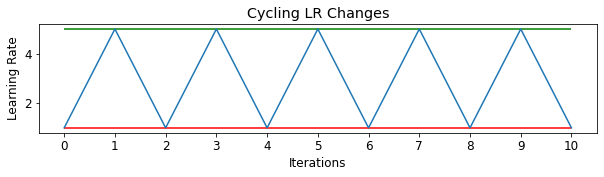

In [3]:
import visualize_data

lr_values = [1,5,1,5,1,5,1,5,1,5,1]
visualize_data.visualize_cycling_sample_plot(min(lr_values), max(lr_values), lr_values)

#### Checking if GPU(CUDA) is supported

In [4]:
cuda = torch.cuda.is_available() # returns True/False
print('GPU Available?', cuda)

# initiate the Network
device = torch.device("cuda" if cuda else "cpu")

GPU Available? True


#### Loading and Transforming the CIFAR10 Dataset

In [5]:
# MODULES: Train and Test Data Loaders modules
import data_loader
trainloader = data_loader.getTrainLoader('CIFAR10')
testloader = data_loader.getTestLoader('CIFAR10')

classes = data_loader.getClasses('CIFAR10')

print('Classes: ')
print(classes)

GPU Available? True
Files already downloaded and verified
Files already downloaded and verified
Classes: 
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### Visualize the training data

In [0]:
# import visualize_data

# visualize_data.visualize_batch(trainloader, classes)

### Creating the Network Object

In [8]:
# Loading the Network
# from network import Net
from models.ResNetMaxPool import ResNet18MaxPool

net = ResNet18MaxPool().to(device)
summary(net, input_size=(3, 32, 32)) # Network Summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
BasicBlockMaxPool-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### Define Loss Criterion, Optimizer

In [0]:
# define Loss Function, Optimizer and Step learning rate

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-2)

### LR Finder
**Reference**: https://github.com/davidtvs/pytorch-lr-finder

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


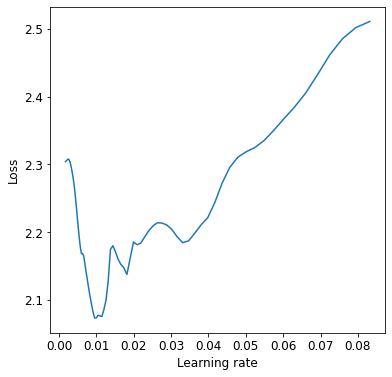

Initial LR using lr_finder():  0.01



Learning rate search finished. See the graph with {finder_name}.plot()


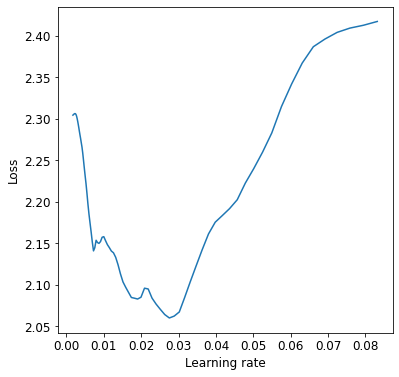

Initial LR using lr_finder():  0.027542287033381664



Learning rate search finished. See the graph with {finder_name}.plot()


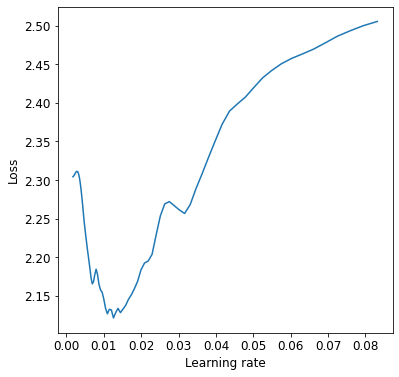

Initial LR using lr_finder():  0.012589254117941675
Learning Rate Finder after number of Trials:
[0.01, 0.027542287033381664, 0.012589254117941675]
New Learning Rate Suggested: 
0.017


In [0]:
import lr_utility
import statistics

lr_finder_trials = 3

min_loss_lr_arr = []
for idx in range(lr_finder_trials):
  lr_history = lr_utility.lr_finder(net, optimizer, loss_fun, trainloader, testloader)

  # Calculating the initial LR with minimum loss as per the lr_finder()
  min_loss = min(lr_history['loss'])
  min_loss_index = lr_history['loss'].index(min_loss)
  min_loss_lr = lr_history['lr'][min_loss_index]
  print('Initial LR using lr_finder(): ', min_loss_lr)
  min_loss_lr_arr.append(min_loss_lr)

print('Learning Rate Finder after number of Trials:')
print(min_loss_lr_arr)

# Avg of LRs found
min_loss_lr = statistics.mean(min_loss_lr_arr)
new_lr = round(min_loss_lr, 3)
print('New Learning Rate Suggested: ')
print(new_lr)

### Updating the Optimizer with new Learning Rate

In [10]:
# Changing the Optimizer with Updated Learning Rate
print('Optimizer BEFORE LRFinder:')
print(optimizer)
for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

print('\nOptimizer AFTER LRFinder:(Notice the LR change)')
print(optimizer)

Optimizer BEFORE LRFinder:
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.05
)

Optimizer AFTER LRFinder:(Notice the LR change)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.012
    momentum: 0.9
    nesterov: False
    weight_decay: 0.05
)


### Define One Cycle Policy

In [0]:
one_cycle_policy_scheduler = OneCycleLR(
        optimizer, new_lr, epochs=24, steps_per_epoch=len(trainloader),
        pct_start=5/24, div_factor=10, final_div_factor=1
    )

### Training Program

In [11]:
# Model Trainer
import model_trainer

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, min_lr=1e-4)

scheduler = one_cycle_policy_scheduler

EPOCHS = 50
# Training and Testing the model
traintestresult = model_trainer.fit_model(net, EPOCHS, device, trainloader, testloader, classes, loss_fun, optimizer, scheduler)
model = traintestresult['model']

  pip install torch-lr-finder -v --global-option="amp"


EPOCH: 1
 [================================================================>]  Step: 282ms | Tot: 40s500ms | Train Loss: 4.334 | Train Acc: 16.208% (8104/50000) 98/98 
 [=============================================================>...]  Step: 83ms | Tot: 2s722ms | Test Loss: 2.073 | Test Acc: 21.820% (2182/10000) 20/20 
EPOCH: 2
 [================================================================>]  Step: 287ms | Tot: 40s684ms | Train Loss: 1.755 | Train Acc: 34.806% (17403/50000) 98/98 
 [=============================================================>...]  Step: 88ms | Tot: 2s752ms | Test Loss: 1.992 | Test Acc: 23.200% (2320/10000) 20/20 
EPOCH: 3
 [================================================================>]  Step: 288ms | Tot: 40s907ms | Train Loss: 1.418 | Train Acc: 48.610% (24305/50000) 98/98 
 [=============================================================>...]  Step: 87ms | Tot: 2s770ms | Test Loss: 1.459 | Test Acc: 45.450% (4545/10000) 20/20 
EPOCH: 4
 [==================

### Train/Test Visualization
Visualizing Training and Testing Results

50
50


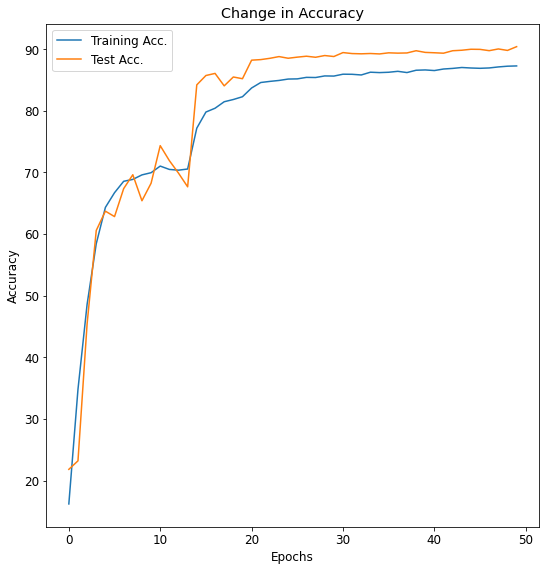

In [12]:
# extract the training/testing metrics
val_acc = traintestresult['val_acc']
val_loss = traintestresult['val_loss']
train_acc = traintestresult['train_acc']
train_loss = traintestresult['train_loss']

# visualize the training/testing stats
visualize_data.visualize_train_test_acc(train_acc, val_acc)

### Class-wise Evaluation Result

Accuracy of plane : 91 %
Accuracy of   car : 71 %
Accuracy of  bird : 100 %
Accuracy of   cat : 57 %
Accuracy of  deer : 100 %
Accuracy of   dog : 92 %
Accuracy of  frog : 83 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %


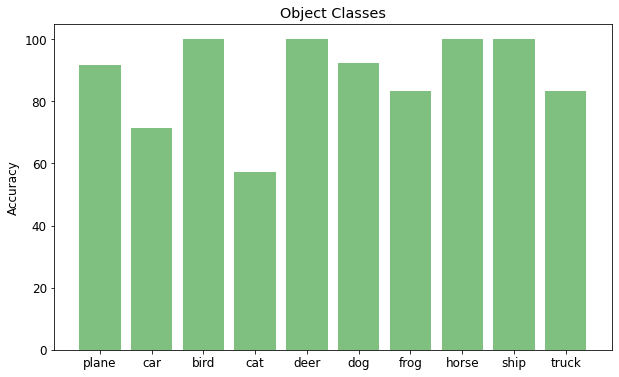

In [13]:
import class_wise_results

class_wise_results.show_class_wise_results(model, testloader, device, classes)

### Plotting Mis-classified Sample Objects

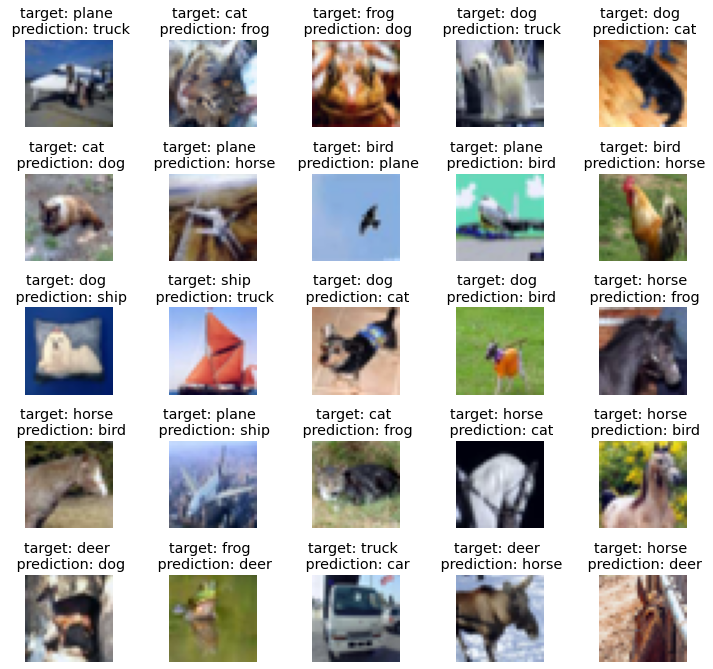

In [14]:
import misclassifieds
# Plotting mis-classified test
failed_samples = misclassifieds.plot_mis_classified_objects(model, device, classes, testloader)

### GradCam Visualization
Visualizing the failed test samples using GradCAM and GradCAM++

In [15]:
# Visualize the GradCam 
from grad_cam_vis import visualize_grad_cam
%matplotlib inline

# Visualizing the GradCAM in the format of:
# Original Image, It's heatmap, heatmap of GradCAM++, Final Result, Final Result using GradCAM++
visualize_grad_cam(model, failed_samples, classes)

AttributeError: ignored